# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.032284,False,-0.034818
1,-0.613785,False,-0.367163
2,-0.394433,False,-0.227469
3,-2.905514,False,-3.994928
4,0.274280,True,5.785218
...,...,...,...
995,-2.194155,False,-3.788945
996,-2.294614,False,-2.451503
997,-1.607354,False,-3.210166
998,-0.603846,False,-0.113808


<AxesSubplot: xlabel='v0'>

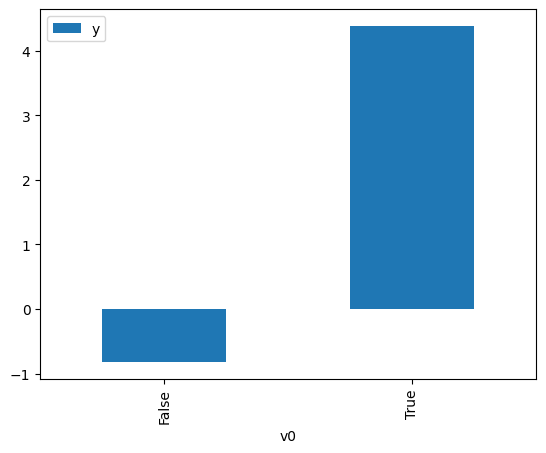

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

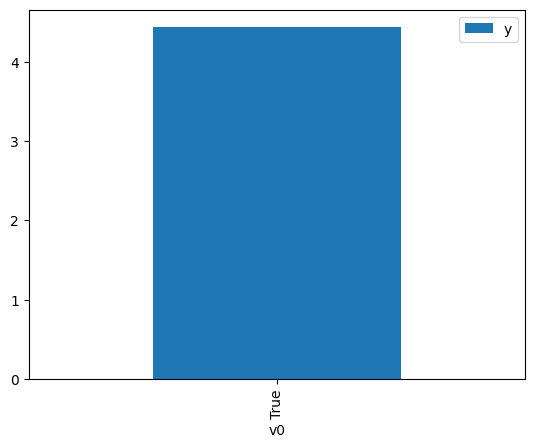

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.885726,False,-0.364971,0.898789,1.112608
1,-0.097279,False,-0.042045,0.586535,1.704927
2,-0.635660,False,-0.102157,0.832313,1.201471
3,-1.322980,False,-1.305128,0.960873,1.040720
4,0.950775,False,2.621303,0.110224,9.072399
...,...,...,...,...,...
995,-1.855692,False,-2.579656,0.988345,1.011792
996,-2.787870,False,-3.115310,0.998653,1.001348
997,-2.025770,False,-1.107604,0.992123,1.007939
998,0.671447,False,1.281145,0.191756,5.214968


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.533548,True,3.663837,0.203500,4.914012
1,1.473211,True,5.357118,0.964559,1.036743
2,-1.170887,True,2.414129,0.054825,18.239740
3,-0.882332,True,3.547947,0.101932,9.810507
4,-0.604681,True,4.148041,0.177988,5.618366
...,...,...,...,...,...
995,0.708529,True,6.244836,0.821260,1.217641
996,-0.448990,True,6.143422,0.237243,4.215083
997,-1.186052,True,1.844468,0.053026,18.858814
998,-0.947192,True,2.289791,0.088925,11.245416


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              5994.
Date:                Mon, 22 May 2023   Prob (F-statistic):                        0.00
Time:                        22:56:42   Log-Likelihood:                         -1431.8
No. Observations:                1000   AIC:                                      2868.
Df Residuals:                     998   BIC:                                      2877.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3862      0.029     47.968      0.000       1.329       1.443
x2             4.9750      0.057     86.597      0.000       4.862       5.088
==============================================================================
Omnibus:                        1.767   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.413   Jarque-Bera (JB):                1.683
Skew:                          -0.099   Prob(JB):                        0.431
Kurtosis:                       3.038   Cond. No.                         2.06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""